In [1]:
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from torch.distributions import Normal
from torch.distributions import kl_divergence

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Assignment 1

In [2]:
class Encoder(nn.Module):
    def __init__(self, zdim):
        super(Encoder, self).__init__()
        self.zdim = zdim
 
        # construct the body
        body_list = [
                    nn.Linear(28*28, self.zdim * 2)
                    ] 
        self.body = nn.Sequential(*body_list)
 
    def forward(self, x):
        scores = self.body(x)
        mu, sigma = torch.split(scores, self.zdim, dim=-1)
        sigma = torch.exp(sigma)
 
        return mu, sigma

class Decoder(nn.Module):
    def __init__(self, zdim):
        super(Decoder, self).__init__()
        # construct the body
        body_list = [
                    nn.Linear(zdim, 28*28)
                    ]
        
        self.body = nn.Sequential(*body_list)
 
    def forward(self, x):
        mu = self.body(x)
 
        return mu

In [3]:
class DeeperEncoder(nn.Module):
    def __init__(self, zdim):
        super(DeeperEncoder, self).__init__()
        self.zdim = zdim
 
        # construct the body
        body_list = [
                    nn.Linear(28*28, 512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Linear(512, 256),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Linear(256, self.zdim * 2)
                    ] 
        self.body = nn.Sequential(*body_list)
 
    def forward(self, x):
        scores = self.body(x)
        mu, sigma = torch.split(scores, self.zdim, dim=-1)
        sigma = torch.exp(sigma)
 
        return mu, sigma

class DeeperDecoder(nn.Module):
    def __init__(self, zdim):
        super(DeeperDecoder, self).__init__()
        # construct the body
        body_list = [
                    nn.Linear(zdim, 256),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Linear(256, 512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),          
                    nn.Linear(512, 28*28)
                    ]
        
        self.body = nn.Sequential(*body_list)
 
    def forward(self, x):
        mu = self.body(x)
 
        return mu

In [4]:
class Data():
    def __init__(self, batch_size=32):
        # transforms
        transform = transforms.Compose([transforms.ToTensor()])        
        self.train_set = torchvision.datasets.MNIST('data', download=True, train=True, transform=transform)
        # dataloaders

        self.data_loader = torch.utils.data.DataLoader(self.train_set, batch_size=batch_size, shuffle=True, num_workers=0)

In [5]:
def compute_elbo(encoder, decoder, x, sigma=0.01):
    qz_mu, qz_sigma = encoder.forward(x)
    
    qz = Normal(qz_mu, qz_sigma)
    
    pz_mu = torch.zeros_like(qz_mu)
    pz_sigma = torch.ones_like(pz_mu)
    pz = Normal(pz_mu, pz_sigma)
    
    kl_div = torch.distributions.kl_divergence(qz, pz)
    
    zs = qz.rsample()
    
    px_mu = decoder.forward(zs)
    px_sigma = sigma*torch.ones_like(px_mu)
    px = Normal(px_mu, px_sigma)
    log_px = px.log_prob(x)
    # print(px_mu.shape, px_sigma.shape)
    # print(log_px.shape, kl_div.shape)
    elbo = log_px.sum(dim=-1) - kl_div.sum(dim=-1)
    
    return elbo

def train_vae(encoder, decoder, data, lr=0.1, epochs=10):
    encoder.train()
    decoder.train()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)
    n_samples = len(data.train_set)
    print(f'Number of training datapoints: {n_samples}')
    elbos = []
    
    for epoch in range(epochs):
        current_elbo = 0
        for i, (x, _) in enumerate(data.data_loader):
            optimizer.zero_grad()
            
            # print(x.flatten(-2, -1).shape)
            elbo = compute_elbo(encoder, decoder, x.flatten(-2, -1).squeeze(1))
            current_elbo += elbo.detach().cpu().sum().numpy()
            elbos.append(elbo.detach().cpu().mean().numpy())
            
            loss = -1*elbo.mean()
            
            loss.backward()

            optimizer.step()
        print(f'Epoch {epoch+1} elbo: {current_elbo / n_samples}')
    return elbos
    

def evaluate_elbo(encoder, decoder, data, sigma=0.01):
    total_elbo = 0
    encoder.eval()
    decoder.eval()
    n_samples = len(data.train_set)
    for i, (x, _) in enumerate(data.data_loader):
        elbos = compute_elbo(encoder, decoder, x.flatten(-2, -1).squeeze(1))
        total_elbo += elbos.detach().cpu().sum().item()
    return total_elbo / n_samples

def ewa(array, q=0.99):
    ewa_array = [array[0]]
    for i in range(1, len(array)):
        ewa_array.append(q * array[i] + (1-q) * ewa_array[-1])
    return np.array(ewa_array)

# Assignment 2 - baseline VAE


In [6]:
from torchvision.utils import make_grid
def visualize_reconstruction(encoder, decoder, batch_size=16, title='Reconstruction'):
    encoder.eval()
    decoder.eval()

    torch.manual_seed(0)
    data = Data(batch_size=batch_size)
    small_batch = next(iter(data.data_loader))[0]

    qz_mu, qz_sigma = encoder.forward(small_batch.flatten(-2, -1).squeeze(1))

    qz = Normal(qz_mu, qz_sigma)

    zs = qz.sample()

    mu = decoder.forward(zs)
    reconstr_images = mu.reshape(batch_size, 1, 28, 28)

    img = make_grid(torch.cat([small_batch, reconstr_images], dim=0), nrow=batch_size, padding=2, normalize=False)
    plt.figure(figsize=(16,9))
    plt.imshow(img.permute(1,2,0).clamp(0,1.).numpy())
    plt.title(title)
    plt.show()

In [7]:
data = Data(batch_size=64)
epochs = 10
z_dim = 128
encoder = Encoder(z_dim)
decoder = Decoder(z_dim)
elbos = train_vae(encoder, decoder, data, lr=10e-4, epochs=epochs)

Number of training datapoints: 60000
Epoch 1 elbo: -74965.904725
Epoch 2 elbo: -18537.948920833333
Epoch 3 elbo: -16166.11140625
Epoch 4 elbo: -15792.268166666667
Epoch 5 elbo: -15700.812075
Epoch 6 elbo: -15665.8847953125
Epoch 7 elbo: -15597.4588328125
Epoch 8 elbo: -15620.758190625
Epoch 9 elbo: -15561.160321354168
Epoch 10 elbo: -15564.222634895834


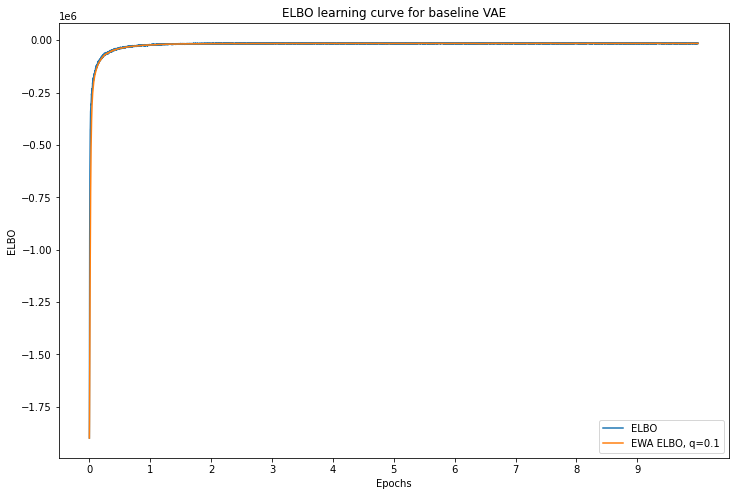

In [8]:
plt.figure(figsize=(12,8))
plt.plot(elbos, label='ELBO')
q=0.1
plt.plot(ewa(elbos, q=q), label= f'EWA ELBO, q={q}')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.title('ELBO learning curve for baseline VAE')
ticks = np.arange(0, len(elbos), len(elbos)//epochs)
plt.xticks(ticks, labels=list(map(str, range(len(ticks)))))
plt.legend()
plt.show()

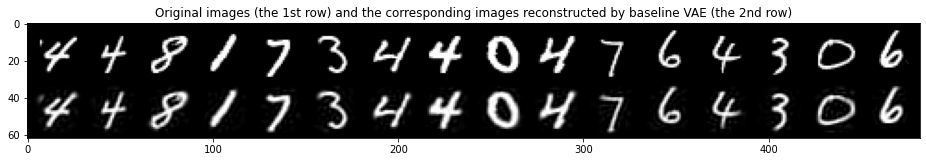

In [9]:
visualize_reconstruction(encoder, decoder, title='Original images (the 1st row) and the corresponding images reconstructed by baseline VAE (the 2nd row)')

In [10]:
encoder_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
decoder_params = sum(p.numel() for p in decoder.parameters() if p.requires_grad)

Baseline VAE encoder has 200960 parameters and corresponding decoder has 101136 paramenters.

# Assignment 2 - deeper VAE

In [23]:
data = Data(batch_size=64)
epochs = 15
z_dim = 128
deeper_encoder = DeeperEncoder(z_dim)
deeper_decoder = DeeperDecoder(z_dim)
elbos_deeper = train_vae(deeper_encoder, deeper_decoder, data, lr=5*10e-3, epochs=epochs)

Number of training datapoints: 60000


ValueError: The parameter loc has invalid values

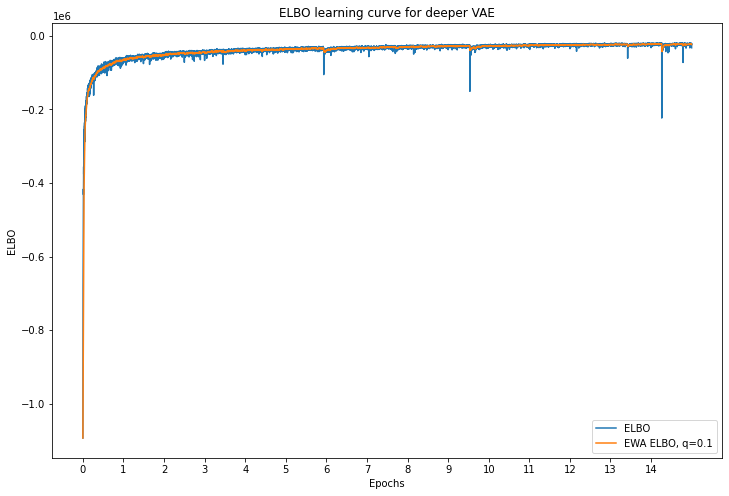

In [12]:
plt.figure(figsize=(12,8))
plt.plot(elbos_deeper, label='ELBO')
q=0.1
plt.plot(ewa(elbos_deeper, q=q), label= f'EWA ELBO, q={q}')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.title('ELBO learning curve for deeper VAE')
ticks = np.arange(0, len(elbos_deeper), len(elbos_deeper)//epochs)
plt.xticks(ticks, labels=list(map(str, range(len(ticks)))))
plt.legend()
plt.show()

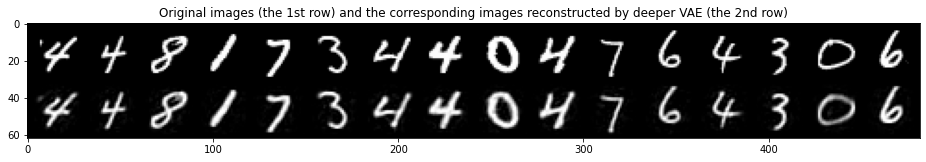

In [13]:
visualize_reconstruction(deeper_encoder, deeper_decoder, title='Original images (the 1st row) and the corresponding images reconstructed by deeper VAE (the 2nd row)')

In [14]:
deeper_encoder_params = sum(p.numel() for p in deeper_encoder.parameters() if p.requires_grad)
deeper_decoder_params = sum(p.numel() for p in deeper_decoder.parameters() if p.requires_grad)

Deeper VAE encoder has 600576 parameters and corresponding decoder has 568336 parameters.

# Assignment 3 - ELBO

In [17]:
final_elbo = round(evaluate_elbo(encoder, decoder, data), 2)
final_elbo_deeper = round(evaluate_elbo(deeper_encoder, deeper_decoder, data), 2)
print(final_elbo, final_elbo_deeper)

Baseline VAE achieved ELBO of ELBO of -132.93 and deeper VAE achieved the VAE of -88.61. Both networks were trained using Adam optimizer with default parameters and learning rate $10^{-4}$. Starndard deviation $\sigma$ used for each component of $p_{\theta}(x|z)$ was 0.01 for both VAEs.

# Assignment 3 - Posterior collapse

In [15]:
def posterior_collapse_metric(encoder, batch_size=256, title='title'):
    encoder.eval()
    torch.manual_seed(0)
    data = Data(batch_size=batch_size)
    small_batch = next(iter(data.data_loader))[0]
    
    qz_mu, qz_sigma = encoder.forward(small_batch.flatten(-2, -1).squeeze(1))
    qz = Normal(qz_mu, qz_sigma)
    
    pz_mu = torch.zeros_like(qz_mu)
    pz_sigma = torch.ones_like(pz_mu)
    pz = Normal(pz_mu, pz_sigma)
    
    kl_div = torch.distributions.kl_divergence(qz, pz)

    kl_div_avg = kl_div.mean(dim=0).squeeze(0)
    plt.hist(kl_div_avg.detach().numpy())
    plt.ylabel('Number of components')
    plt.xlabel('Averaged KL-divergence')
    plt.title(title)
    plt.show()

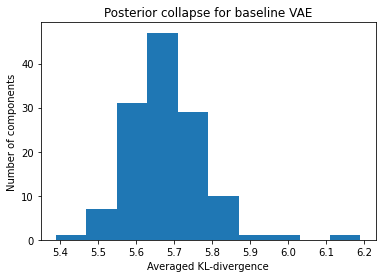

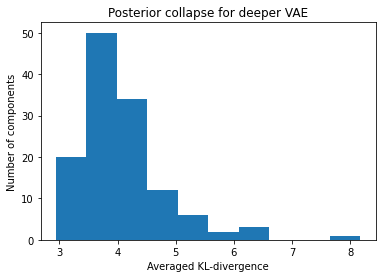

In [16]:
posterior_collapse_metric(encoder, title='Posterior collapse for baseline VAE')
posterior_collapse_metric(deeper_encoder, title='Posterior collapse for deeper VAE')

Two figures above show that around 65 components out of 128 collapsed of baseline VAE collapsed. Compared to that, around 105 components out of 128 collapsed of deeper VAE collapsed.

# Assignment 3 - Evaluating the decoder

In [17]:
def evaluate_decoder(decoder, zdim=128, batch_size=64, title='title'):
    decoder.eval()
    torch.manual_seed(0)
    z_mean = torch.zeros(zdim)
    z_sigma = torch.ones_like(z_mean)
    pz = Normal(z_mean, z_sigma)
    zs = pz.sample((batch_size, ))
    # print(zs.shape)
    mu = decoder.forward(zs)
    reconstr_images = mu.reshape(batch_size, 1, 28, 28)
    
    img = make_grid(reconstr_images, nrow=8, padding=1, pad_value=1., normalize=False)
    plt.figure(figsize=(16,9))
    plt.imshow(img.permute(1,2,0).clamp(0,1.).numpy())
    plt.show()
    

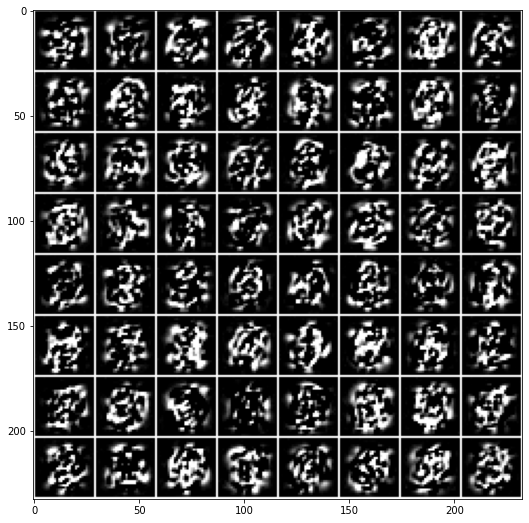

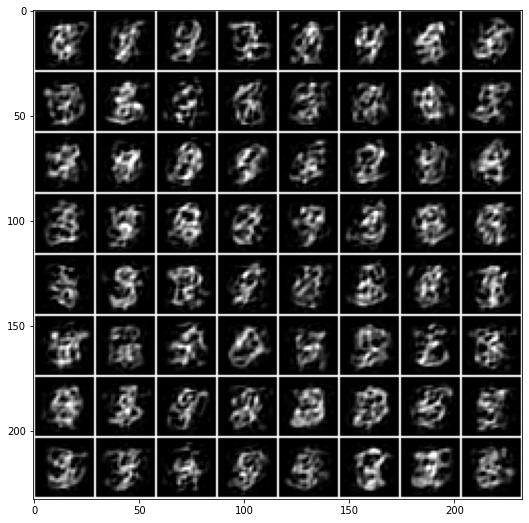

In [18]:
evaluate_decoder(decoder, title='Evaluating the decoder for the baseline VAE')
evaluate_decoder(deeper_decoder, title='Evaluating the decoder for the deeper VAE')

# Assignment 4 - Limiting the distribution

In [19]:
import cv2
def limiting_distribution(encoder, decoder, fname='title', batch_size=64, n_frames=100, sigma=0.01, z_dim=128):
    encoder.eval()
    decoder.eval()
    torch.manual_seed(1)
    pz_mu = torch.zeros(z_dim)
    pz_sigma = torch.ones_like(pz_mu)
    pz = Normal(pz_mu, pz_sigma)
    
    
    zs = pz.sample((batch_size, ))
    
    images = []
    
    for i in range(n_frames):
        # decode
        px_mu = decoder.forward(zs)
        mu = px_mu.reshape(batch_size, 1, 28, 28)
        
        # create image 
        grid = make_grid(mu, nrow=8, padding=1, pad_value=1.)
        image = grid.permute(1,2,0).clamp(0,1.).numpy()
        images.append(image) 
        
        px_sigma = sigma*torch.ones_like(px_mu)
        px = Normal(px_mu, px_sigma)
        
        # sample
        xs = px.sample()
        
        # encode
        qz_mu, qz_sigma = encoder.forward(xs)
        # print(i, torch.min(qz_sigma), torch.max(qz_sigma))
        qz = Normal(qz_mu, qz_sigma)
        
        zs = qz.sample()
 
    # inspired by https://theailearner.com/2018/10/15/creating-video-from-images-using-opencv-python/
    size = images[0].shape[:2]
    out = cv2.VideoWriter(f'{fname}.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 10, size)
 
    for image in images:
        # print(image.shape)
        out.write((image*255).astype(np.uint8))
    out.release()
    

In [20]:
limiting_distribution(encoder, decoder, fname='baseline_vae')
limiting_distribution(deeper_encoder, deeper_decoder, fname='deeper_vae')

ValueError: The parameter scale has invalid values